In [1]:
#------------------------------------#
#------------- packages--------------#
#------------------------------------#

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import math
from scipy.stats import shapiro, lognorm, ttest_ind, pearsonr

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# from sklearn.preprocessing import MinMaxScaler

# show multiple outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"


import cufflinks as cf
from plotly import plot
cf.go_offline()
import os

In [2]:
#------------------------------------#
#-------read check-in survey---------#
#------------------------------------#

survey_daily = pd.read_csv("/Users/beatriceli/Documents/PhD_Research/GitHub/well-being/cleaned-surveys/daily.csv",parse_dates=["StartDate","EndDate","Q15","Q6"])
# survey_daily["date"] = merged_fit_survey["RecordedDate"].dt.date
# merged_fit_survey["surveyTime"] = pd.to_datetime(merged_fit_survey["RecordedDate"]).dt.time

incomp = survey_daily[(survey_daily['Finished'] == False)].index
survey_daily.drop(incomp, inplace=True)
# len(survey_daily)
survey_daily=survey_daily.drop(['RecipientLastName','StartDate','Progress','Duration (in seconds)','Finished','RecordedDate','LocationLatitude','LocationLongitude'], axis=1)
survey_daily['date'] = survey_daily['EndDate'].dt.date
# attention check
survey_daily=survey_daily.drop(['Q33_1', 'Q34_1','Q35_1','Q36_1','Q37_1'], axis=1)
survey_daily.reset_index(inplace=True)
survey_daily = survey_daily.rename(columns = {'index':'survey_index','Q15':'rep_bedtime','Q6':'rep_wakeup'})

# convert EndDate,rep_bedtime,rep_wakeup to datetime
survey_daily['EndDate'] = pd.to_datetime(survey_daily['EndDate'])
survey_daily['rep_bedtime'] = pd.to_datetime(survey_daily['rep_bedtime'])
survey_daily['rep_wakeup'] = pd.to_datetime(survey_daily['rep_wakeup'])

# calculate reported sleep duration
survey_daily['repDuration'] = survey_daily['rep_wakeup'] - survey_daily['rep_bedtime']
survey_daily['repDuration'] = survey_daily['repDuration'].dt.total_seconds()

survey_daily.head()

,survey_index,EndDate,Q3_1,Q4,rep_bedtime,rep_wakeup,Q28,Q29,Q22_1,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,pid,date,repDuration
0,0,2022-04-27 10:15:00,5.0,None,2022-04-27 00:30:00,2022-04-27 07:20:00,Did not exercise,"My Friends,My colleagues/classsmates/students",NaN,4.0,5.0,"Neutral,Stressed",NaN,Work,edr,2022-04-27,24600.0
1,1,2022-04-27 12:55:00,4.0,None,2022-04-27 00:40:00,2022-04-27 09:00:00,In the afternoon,"My Friends,My colleagues/classsmates/students",NaN,NaN,5.0,Neutral,NaN,Work,egl,2022-04-27,30000.0
2,2,2022-04-27 14:13:00,NaN,Twice,2022-04-27 02:35:00,2022-04-27 10:30:00,In the evening,"My Friends,New people",2.0,3.0,3.0,Stressed,NaN,Work,uja,2022-04-27,28500.0
3,3,2022-04-28 11:55:00,3.0,Twice,2022-04-28 03:15:00,2022-04-28 10:30:00,Did not exercise,My Friends,4.0,3.0,3.0,"Neutral,Sadness,Frustrated",NaN,"Work,Sleep",uja,2022-04-28,26100.0
4,4,2022-04-28 13:51:00,5.0,None,2022-04-28 02:00:00,2022-04-28 10:00:00,In the evening,"My Family,My Friends,My colleagues/classsmates...",5.0,NaN,6.0,"Neutral,Happiness",NaN,"Work,Personal",edr,2022-04-28,28800.0


## Step Count from Fitbit

In [3]:
#------------------------------------#
#----------- read step data ---------#
#------------------------------------#

all_step = []

for r,d,f in os.walk("/Users/beatriceli/Documents/PhD_Research/GitHub/well-being/lll_fitbit_data"):
    for file in f:
        if file.endswith("steps.csv"):
            temp = pd.read_csv(os.path.join(r,file),parse_dates=["pid"])
            #temp["value"] = (temp["value"] - temp["value"].min()) 
            all_step.append(temp)

all_step = pd.concat(all_step)
all_step.columns = ["pid","Timestamp","value"]
# Convert to Datetime object
all_step['Timestamp'] = pd.to_datetime(all_step['Timestamp'], format="%Y-%m-%d %H:%M:%S")
all_step["day"] = all_step["Timestamp"].dt.day_name()
all_step["date"] = pd.to_datetime(all_step["Timestamp"]).dt.date

# remove participants n3f and iyl
all_step = all_step[all_step['pid'] != 'iyl']
all_step = all_step[all_step['pid'] != 'n3f']

all_step = all_step.sort_values(by=['pid','Timestamp'])
# rename value to steps
all_step = all_step.rename(columns = {'value':'steps'})

all_step.head()


,pid,Timestamp,steps,day,date
0,edr,2022-04-26 00:00:00,0,Tuesday,2022-04-26
1,edr,2022-04-26 00:01:00,0,Tuesday,2022-04-26
2,edr,2022-04-26 00:02:00,0,Tuesday,2022-04-26
3,edr,2022-04-26 00:03:00,0,Tuesday,2022-04-26
4,edr,2022-04-26 00:04:00,0,Tuesday,2022-04-26


## Sleep Data from Fitbit

In [4]:
#------------------------------------#
#---------- read sleep data ---------#
#------------------------------------#

all_sleep = []

for r,d,f in os.walk("/Users/beatriceli/Documents/PhD_Research/GitHub/well-being/lll_fitbit_data"):
    for file in f:
        if file.endswith("sleep.csv"):
            temp = pd.read_csv(os.path.join(r,file),parse_dates=["pid"])
            #temp["value"] = (temp["value"] - temp["value"].min()) 
            all_sleep.append(temp)

all_sleep = pd.concat(all_sleep)
all_sleep.columns = ["pid","Timestamp","stage","length"]
# Convert to Datetime object
all_sleep['Timestamp'] = pd.to_datetime(all_sleep['Timestamp'], format="%Y-%m-%d %H:%M:%S")
all_sleep["date"] = pd.to_datetime(all_sleep["Timestamp"]).dt.date
all_sleep["time"] = pd.to_datetime(all_sleep["Timestamp"]).dt.time

# remove participants n3f and iyl
all_sleep = all_sleep[all_sleep['pid'] != 'iyl']
all_sleep = all_sleep[all_sleep['pid'] != 'n3f']
# pgm only has 4 nights of sleep data
all_sleep = all_sleep[all_sleep['pid'] != 'pgm']

all_sleep = all_sleep.sort_values(by=['pid','Timestamp'])

all_sleep.head()

# all_sleep.groupby('pid').size()

,pid,Timestamp,stage,length,date,time
87,edr,2022-04-27 00:51:00,wake,30,2022-04-27,00:51:00
88,edr,2022-04-27 00:51:30,light,2640,2022-04-27,00:51:30
89,edr,2022-04-27 01:35:30,deep,270,2022-04-27,01:35:30
90,edr,2022-04-27 01:40:00,light,2130,2022-04-27,01:40:00
91,edr,2022-04-27 02:15:30,rem,1320,2022-04-27,02:15:30


In [5]:
# create timestamp2 column where timestamp is added by length
all_sleep['Timestamp2'] = all_sleep['Timestamp'] + pd.to_timedelta(all_sleep['length'], unit='s')

In [6]:
# chunk sleep data based on time difference between rows being greater then 6000 sec
pids = all_sleep["pid"].unique()

slp = []

for p in pids:
    temp = all_sleep[all_sleep["pid"]==p]
    temp = temp.sort_values(by='Timestamp')
    # calculate difference between timestamp in current row and timestamp2 in previous row in seconds for each participant
    temp['diff'] = (temp['Timestamp'] - temp['Timestamp2'].shift(1)).dt.total_seconds()
    # if time difference between rows being greater then 6000 sec, then next row is a new group
    temp['group'] = (temp['diff'] > 6000).cumsum()
    slp.append(temp)

slp = pd.concat(slp).reset_index(drop=True)
slp['day_name'] = slp["Timestamp"].dt.day_name()
# drop timestamp2 and diff columns
slp = slp.drop(columns=['Timestamp2','diff'])
# slp_dist.nights.mean()
slp.head()

,pid,Timestamp,stage,length,date,time,group,day_name
0,edr,2022-04-27 00:51:00,wake,30,2022-04-27,00:51:00,0,Wednesday
1,edr,2022-04-27 00:51:30,light,2640,2022-04-27,00:51:30,0,Wednesday
2,edr,2022-04-27 01:35:30,deep,270,2022-04-27,01:35:30,0,Wednesday
3,edr,2022-04-27 01:40:00,light,2130,2022-04-27,01:40:00,0,Wednesday
4,edr,2022-04-27 02:15:30,rem,1320,2022-04-27,02:15:30,0,Wednesday


In [7]:
sleep = slp.groupby(["pid","stage","group"])["length"].sum().reset_index()
# sleep = sleep.set_index(["pid","date","levels","group"])["length"].unstack()
sleep = sleep.pivot(index=["pid","group",], columns='stage', values='length').reset_index()
sleep = sleep.rename_axis(None, axis=1)
sleep = sleep.fillna(0)

# get first time in groupby as bedtime
bedtime = slp.groupby(["pid","group"])["day_name","date","time",'Timestamp'].nth(0).reset_index()
bedtime.rename(columns={'Timestamp':'bedtime'}, inplace=True)

# get last time in groupby and add length for that timestamp as wakeup
wakeup = slp.groupby(["pid","group"])["date","time",'Timestamp','length'].nth(-1).reset_index()
wakeup.rename(columns={'Timestamp':'wakeup'}, inplace=True)
# cast length as timedelta seconds to add to wakeup time
wakeup["length"] = pd.to_timedelta(wakeup["length"], unit='s')
wakeup["wakeup"] = wakeup["wakeup"] + wakeup["length"]
# drop length column from wakeup
wakeup = wakeup.drop(columns=['length'])


sleep_times = pd.merge(bedtime, wakeup, on=["pid","group"])
sleep_times.rename(columns={'date_x':'startDate','date_y':'endDate','time_x':'startTime','time_y':'endTime'}, 
                   inplace=True)
sleep_times["day_name"][sleep_times["startDate"]==bedtime["date"]] = bedtime["day_name"]
sleep_times = sleep_times.reindex(columns=['pid','day_name','group','bedtime','wakeup'])

SLP = pd.merge(sleep_times, sleep, on=["pid", "group"])
# SLP = SLP.rename(columns={'endDate':'date'})
slp2 = []

for p in pids:
    temp = SLP[SLP['pid'] == p]
    slp2.append(temp)

slp2 = pd.concat(slp2)
slp2.head()

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76261/2157140812.py:8: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76261/2157140812.py:12: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,pid,day_name,group,bedtime,wakeup,asleep,awake,deep,light,rem,restless,wake
0,edr,Wednesday,0,2022-04-27 00:51:00,2022-04-27 07:41:00,0,0,3540,13080,6960,0,1020
1,edr,Thursday,1,2022-04-28 01:51:00,2022-04-28 10:30:00,0,0,6060,15480,5940,0,3660
2,edr,Friday,2,2022-04-29 01:13:00,2022-04-29 09:07:30,0,0,4110,16260,6540,0,1560
3,edr,Friday,3,2022-04-29 17:18:30,2022-04-29 18:44:30,4620,0,0,0,0,540,0
4,edr,Saturday,4,2022-04-30 02:20:00,2022-04-30 07:37:30,0,0,3330,13110,1140,0,1470


In [8]:
#  get total number of nights of sleep data
slp2.groupby('pid').size()

pid
edr    54
egl    69
h9u    69
heh    69
j02    28
lpz    77
mr1    78
oyb    45
ssg    65
uja    87
vxx    18
xil    72
dtype: int64

In [9]:
# get sum of observations
slp2.groupby('pid').size().sum()

731

In [10]:
slp2.head()

,pid,day_name,group,bedtime,wakeup,asleep,awake,deep,light,rem,restless,wake
0,edr,Wednesday,0,2022-04-27 00:51:00,2022-04-27 07:41:00,0,0,3540,13080,6960,0,1020
1,edr,Thursday,1,2022-04-28 01:51:00,2022-04-28 10:30:00,0,0,6060,15480,5940,0,3660
2,edr,Friday,2,2022-04-29 01:13:00,2022-04-29 09:07:30,0,0,4110,16260,6540,0,1560
3,edr,Friday,3,2022-04-29 17:18:30,2022-04-29 18:44:30,4620,0,0,0,0,540,0
4,edr,Saturday,4,2022-04-30 02:20:00,2022-04-30 07:37:30,0,0,3330,13110,1140,0,1470


### Merge FitBit Sleep data with Daily Surveys

In [11]:
#------------------------------------#
#----------- Sleep Quality ----------#
#------------------------------------#
SLP = slp2

# TST (Time spent asleep): light+deep+REM
SLP['TST'] = ((SLP['deep'] + SLP['light'] + SLP['rem'] + SLP['asleep'])/3600)
# Ratio of REM to nREM: REM/(light+deep); recc: 0.25 to 0.33
SLP['REM:nREM'] = (SLP['rem']/(SLP['deep'] + SLP['light']))

SLP['duration'] = SLP['wakeup'] - SLP['bedtime']
SLP['duration'] = SLP['duration'].dt.total_seconds()

SLP['date'] = SLP['wakeup'].dt.date
# SLP['startTime'] = SLP['startTime'].dt.time
# SLP['endTime'] = SLP['endTime'].dt.time

selected_columns = SLP[['pid','group','date','day_name','bedtime','wakeup','duration','TST','REM:nREM','deep','light','rem']]
SQI = selected_columns.copy()

# merge fitbit and survey
# joining data on the end_date of the sleep segment so match the daily survey for the night before 
merged_fit_survey = pd.merge(SQI,survey_daily, on=["pid","date"])
# # create new column for sleep night right after pid
# merged_fit_survey.insert(1, 'sleepNight', range(1, 1 + len(merged_fit_survey)))


merged_fit_survey.rename(columns={'date':'wakeDate'}, inplace=True)
merged_fit_survey.head()

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,rep_wakeup,Q28,Q29,Q22_1,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,repDuration
0,edr,0,2022-04-27,Wednesday,2022-04-27 00:51:00,2022-04-27 07:41:00,24600.0,6.550000,0.418773,3540,...,2022-04-27 07:20:00,Did not exercise,"My Friends,My colleagues/classsmates/students",NaN,4.0,5.0,"Neutral,Stressed",NaN,Work,24600.0
1,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,...,2022-04-28 10:00:00,In the evening,"My Family,My Friends,My colleagues/classsmates...",5.0,NaN,6.0,"Neutral,Happiness",NaN,"Work,Personal",28800.0
2,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,...,2022-04-29 09:04:00,Did not exercise,"My Friends,My colleagues/classsmates/students",5.0,NaN,NaN,"Neutral,Happiness,Excited",NaN,"Work,Personal",28560.0
3,edr,3,2022-04-29,Friday,2022-04-29 17:18:30,2022-04-29 18:44:30,5160.0,1.283333,NaN,0,...,2022-04-29 09:04:00,Did not exercise,"My Friends,My colleagues/classsmates/students",5.0,NaN,NaN,"Neutral,Happiness,Excited",NaN,"Work,Personal",28560.0
4,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,...,2022-05-02 08:20:00,Did not exercise,"My Family,My Friends,My colleagues/classsmates...",4.0,4.0,6.0,Neutral,NaN,Work,26400.0


In [12]:
# get headers
merged_fit_survey.columns

Index(['pid', 'group', 'wakeDate', 'day_name', 'bedtime', 'wakeup', 'duration',
       'TST', 'REM:nREM', 'deep', 'light', 'rem', 'survey_index', 'EndDate',
       'Q3_1', 'Q4', 'rep_bedtime', 'rep_wakeup', 'Q28', 'Q29', 'Q22_1',
       'Q23_1', 'Q27_1', 'Q34', 'Q34_6_TEXT', 'Q35', 'repDuration'],
      dtype='object')

In [13]:
# get amount of null values in each column
merged_fit_survey.isnull().sum()


pid               0
group             0
wakeDate          0
day_name          0
bedtime           0
wakeup            0
duration          0
TST               0
REM:nREM         74
deep              0
light             0
rem               0
survey_index      0
EndDate           0
Q3_1             27
Q4                0
rep_bedtime       0
rep_wakeup        0
Q28               1
Q29               0
Q22_1            77
Q23_1            88
Q27_1            83
Q34               0
Q34_6_TEXT      489
Q35               2
repDuration       0
dtype: int64

In [14]:
# merged_fit_survey.dtypes
merged_fit_survey.groupby('pid').size()

pid
edr    37
egl    52
h9u    68
heh    55
j02    21
lpz    57
mr1    42
oyb    33
ssg    45
uja    51
vxx    18
xil    45
dtype: int64

In [15]:
#  add up all the sleep data for each participant
merged_fit_survey.groupby('pid').size().sum()

524

#### Check sleep data against each other

In [16]:
# check if we assigned the wrong date to the self reported wake
# how much does reported duration differ from fitbit duration - within 5 hr
merged_fit_survey['diffDuration'] = abs(merged_fit_survey['repDuration'] - merged_fit_survey['duration'])
merged_fit_survey['within_dur'] = np.where(merged_fit_survey['diffDuration'] >= 18000, False, True)

In [17]:
# check if bedtime is in morning - between 6am and 11:59am (subtract 12 hours), between 12pm and 4pm (add 12 hours)
# check if wakeup is at night - 4pm to 11pm, subtract 12 hrs
ind = merged_fit_survey.index[merged_fit_survey['within_dur'] == False].tolist()
t4pm = pd.to_datetime('16:00').time() 
t11pm = pd.to_datetime('23:59').time()
t6am = pd.to_datetime('06:00').time()
t11am = pd.to_datetime('11:59').time()
t12pm = pd.to_datetime('12:00').time()

for i in ind:
    if (t6am <= merged_fit_survey['rep_bedtime'][i].time()) & (merged_fit_survey['rep_bedtime'][i].time() <= t11am):
        # print(i,merged_fit_survey['rep_bedtime'][i])
        merged_fit_survey['rep_bedtime'][i] = merged_fit_survey['rep_bedtime'][i] - pd.Timedelta(hours=12)
    if (t12pm <= merged_fit_survey['rep_bedtime'][i].time()) & (merged_fit_survey['rep_bedtime'][i].time() <= t4pm):
        # print(i,merged_fit_survey['rep_bedtime'][i])
        merged_fit_survey['rep_bedtime'][i] = merged_fit_survey['rep_bedtime'][i] + pd.Timedelta(hours=12)
    if (t4pm <= merged_fit_survey['rep_wakeup'][i].time()) & (merged_fit_survey['rep_wakeup'][i].time() <= t11pm):
    # check if wakeup is at night - 4pm to 11pm, subtract 12 hrs
        merged_fit_survey['rep_wakeup'][i] = merged_fit_survey['rep_wakeup'][i] - pd.Timedelta(hours=12)
        # print(i,merged_fit_survey['rep_wakeup'][i]-pd.Timedelta(hours=12))

# recalculate reported duration
merged_fit_survey['repDuration'] = merged_fit_survey['rep_wakeup'] - merged_fit_survey['rep_bedtime']
merged_fit_survey['repDuration'] = merged_fit_survey['repDuration'].dt.total_seconds()

# recalculate difference in duration
merged_fit_survey['diffDuration'] = abs(merged_fit_survey['repDuration'] - merged_fit_survey['duration'])

In [18]:
# create column night to keep track of fitbit sleep data
# start with 1 for the first row of each pid
# if the next row has the same pid and the fitbit bedtime is between the rep_bedtime and rep_wakeup of the previous row, then it is the same night and give it the same night count
# if the next row has the same pid and the fitbit bedtime is not between the rep_bedtime and rep_wakeup, then it is the next night and increment the night count
# if the next row has a different pid, then start over counting the nights
merged_fit_survey['night'] = 1
for i in range(1,len(merged_fit_survey)):
    if merged_fit_survey['pid'][i] == merged_fit_survey['pid'][i-1]:
        if (merged_fit_survey['rep_bedtime'][i-1] <= merged_fit_survey['bedtime'][i]) & (merged_fit_survey['bedtime'][i] <= merged_fit_survey['rep_wakeup'][i-1]):
            merged_fit_survey['night'][i] = merged_fit_survey['night'][i-1]
        else:
            merged_fit_survey['night'][i] = merged_fit_survey['night'][i-1] + 1
    else:
        merged_fit_survey['night'][i] = 1


In [19]:
timecheck = []
# get index of rows where within_dur is False
# get rows before and after each i in ind to see whats going on
ind = merged_fit_survey.index[merged_fit_survey['within_dur'] == False].tolist()
# dont add repeated rows  - check if i-1 or i+1 is in ind
for i in ind:
    if (i-1) not in ind:
        timecheck.append(i-1)
    if (i+1) not in ind:
        timecheck.append(i+1)
    timecheck.append(i)

# sort and convert to csv
# timecheck = sorted(timecheck)
# timecheck = merged_fit_survey.iloc[timecheck]
# timecheck.to_csv('timecheck.csv')

In [20]:
# within_dur was set to 5 hours to correct for survey time (AM/PM)
# remove within_dur column
merged_fit_survey.drop('within_dur', axis=1, inplace=True)
merged_fit_survey.head()

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,Q29,Q22_1,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,repDuration,diffDuration,night
0,edr,0,2022-04-27,Wednesday,2022-04-27 00:51:00,2022-04-27 07:41:00,24600.0,6.550000,0.418773,3540,...,"My Friends,My colleagues/classsmates/students",NaN,4.0,5.0,"Neutral,Stressed",NaN,Work,24600.0,0.0,1
1,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,...,"My Family,My Friends,My colleagues/classsmates...",5.0,NaN,6.0,"Neutral,Happiness",NaN,"Work,Personal",28800.0,2340.0,2
2,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,...,"My Friends,My colleagues/classsmates/students",5.0,NaN,NaN,"Neutral,Happiness,Excited",NaN,"Work,Personal",28560.0,90.0,3
3,edr,3,2022-04-29,Friday,2022-04-29 17:18:30,2022-04-29 18:44:30,5160.0,1.283333,NaN,0,...,"My Friends,My colleagues/classsmates/students",5.0,NaN,NaN,"Neutral,Happiness,Excited",NaN,"Work,Personal",28560.0,23400.0,4
4,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,...,"My Family,My Friends,My colleagues/classsmates...",4.0,4.0,6.0,Neutral,NaN,Work,26400.0,480.0,5


In [21]:
# difference betwen reported bedtime and fitbit bedtime
merged_fit_survey['diff_bedtime'] = abs(merged_fit_survey['bedtime'] - merged_fit_survey['rep_bedtime'])
# check if the absolute difference between bedtime and rep_bedtime is less than or equal to 3 hours
merged_fit_survey['bedtime_le3hr'] = np.where(merged_fit_survey['diff_bedtime'] <= pd.Timedelta(hours=3), True, False)

# difference betwen reported wake and fitbit wake
merged_fit_survey['diff_wake'] = abs(merged_fit_survey['wakeup'] - merged_fit_survey['rep_wakeup'])
# check if the absolute difference between fitbit wakeup and reported is less than or equal to 3 hours
merged_fit_survey['wake_le3hr'] = np.where(merged_fit_survey['diff_wake'] <= pd.Timedelta(hours=3), True, False)

# drop diff_wake column
merged_fit_survey.drop('diff_wake', axis=1, inplace=True)
# drop diff_bedtime column
merged_fit_survey.drop('diff_bedtime', axis=1, inplace=True)

merged_fit_survey.head()

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,repDuration,diffDuration,night,bedtime_le3hr,wake_le3hr
0,edr,0,2022-04-27,Wednesday,2022-04-27 00:51:00,2022-04-27 07:41:00,24600.0,6.550000,0.418773,3540,...,4.0,5.0,"Neutral,Stressed",NaN,Work,24600.0,0.0,1,True,True
1,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,...,NaN,6.0,"Neutral,Happiness",NaN,"Work,Personal",28800.0,2340.0,2,True,True
2,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,...,NaN,NaN,"Neutral,Happiness,Excited",NaN,"Work,Personal",28560.0,90.0,3,True,True
3,edr,3,2022-04-29,Friday,2022-04-29 17:18:30,2022-04-29 18:44:30,5160.0,1.283333,NaN,0,...,NaN,NaN,"Neutral,Happiness,Excited",NaN,"Work,Personal",28560.0,23400.0,4,False,False
4,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,...,4.0,6.0,Neutral,NaN,Work,26400.0,480.0,5,True,True


In [22]:
# create column check with null value
merged_fit_survey['check'] = np.nan

# if wake_le3hr AND bedtime_le3hr is False, then look to see if night columnn is the same as the previous or next night column value
# if it is the same, then set "check" to True
# if it is not the same, then set "check" to False
for i in range(0,len(merged_fit_survey)):
    if (merged_fit_survey['wake_le3hr'][i] == False) & (merged_fit_survey['bedtime_le3hr'][i] == False):
        if merged_fit_survey['night'][i] == merged_fit_survey['night'][i-1]:
            merged_fit_survey['check'][i] = True
        elif merged_fit_survey['night'][i] == merged_fit_survey['night'][i+1]:
            merged_fit_survey['check'][i] = True
        else:
            merged_fit_survey['check'][i] = False
    else:
        merged_fit_survey['check'][i] = True

In [23]:
# count number of False in check column
merged_fit_survey['check'].value_counts()

True     458
False     66
Name: check, dtype: int64

In [24]:
# check how many False in check column for each pid
merged_fit_survey.groupby('pid')['check'].value_counts()

pid  check
edr  True     33
     False     4
egl  True     51
     False     1
h9u  True     59
     False     9
heh  True     53
     False     2
j02  True     14
     False     7
lpz  True     50
     False     7
mr1  True     36
     False     6
oyb  True     32
     False     1
ssg  True     36
     False     9
uja  True     44
     False     7
vxx  False    11
     True      7
xil  True     43
     False     2
Name: check, dtype: int64

### Filter Sleep Observations

In [25]:
# drop rows where check is False
slpfilt = merged_fit_survey
slpfilt.drop(merged_fit_survey[merged_fit_survey['check'] == False].index, inplace=True)
# drop check column
slpfilt.drop('check', axis=1, inplace=True)

# if bedtime is after wakeup time
slpfilt['bedtime_before'] = np.where(slpfilt['rep_bedtime'] > slpfilt['rep_wakeup'], False, True)
# bedbefore = slpfilt[slpfilt['bedtime_before'] == False]
# there is onw rows where rep_bedtime is after rep_wakeup, the fitbit sleep observations also seem to be naps/outside of reported range
# bedbefore.to_csv('bedbefore.csv')

# drop bedtime_before == False
slpfilt.drop(merged_fit_survey[slpfilt['bedtime_before'] == False].index, inplace=True)
# drop bedtime_before column
slpfilt.drop('bedtime_before', axis=1, inplace=True)

In [26]:
slpfilt.head()

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,repDuration,diffDuration,night,bedtime_le3hr,wake_le3hr
0,edr,0,2022-04-27,Wednesday,2022-04-27 00:51:00,2022-04-27 07:41:00,24600.0,6.550000,0.418773,3540,...,4.0,5.0,"Neutral,Stressed",NaN,Work,24600.0,0.0,1,True,True
1,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,...,NaN,6.0,"Neutral,Happiness",NaN,"Work,Personal",28800.0,2340.0,2,True,True
2,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,...,NaN,NaN,"Neutral,Happiness,Excited",NaN,"Work,Personal",28560.0,90.0,3,True,True
4,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,...,4.0,6.0,Neutral,NaN,Work,26400.0,480.0,5,True,True
5,edr,6,2022-05-03,Tuesday,2022-05-03 01:13:00,2022-05-03 08:22:30,25770.0,6.250000,0.315789,2100,...,NaN,3.0,"Neutral,Stressed",NaN,Work,25560.0,210.0,6,True,True


In [27]:
# get rows where duration is less than 2 hours in seconds (7200)
slpfilt[slpfilt['duration'] < 7200]
# there are 3 rows where duration is less than 2 hours
# drop these rows
slpfilt.drop(merged_fit_survey[slpfilt['duration'] < 7200].index, inplace=True)

In [28]:
# get number of sleep records for each participant
slpfilt.groupby('pid').size()

pid
edr    33
egl    51
h9u    59
heh    53
j02    14
lpz    50
mr1    36
oyb    29
ssg    36
uja    44
vxx     6
xil    43
dtype: int64

In [29]:
# get mean number of sleep records for each participant
print(slpfilt.groupby('pid').size().mean())
print(slpfilt.groupby('pid').size().std())
print(slpfilt.groupby('pid').size().sum())

37.833333333333336
15.821925715074425
454


In [30]:
# look at pid vxx 
slpfilt[slpfilt['pid'] == 'vxx']

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,repDuration,diffDuration,night,bedtime_le3hr,wake_le3hr
461,vxx,0,2022-05-15,Saturday,2022-05-14 19:12:00,2022-05-15 01:28:30,22590.0,5.758333,0.107372,450,...,4.0,6.0,"Happiness,Excited",NaN,"Work,Personal",25200.0,2610.0,1,True,False
462,vxx,1,2022-05-15,Sunday,2022-05-15 04:48:30,2022-05-15 07:40:30,10320.0,2.616667,NaN,0,...,4.0,6.0,"Happiness,Excited",NaN,"Work,Personal",25200.0,14880.0,1,False,True
472,vxx,11,2022-06-12,Sunday,2022-06-12 04:34:30,2022-06-12 07:49:30,11700.0,3.066667,0.533333,1230,...,4.0,5.0,"Neutral,Excited",NaN,"Health,Sleep",32400.0,20700.0,11,False,True
473,vxx,12,2022-06-13,Monday,2022-06-13 06:21:00,2022-06-13 09:03:00,9720.0,2.450000,NaN,0,...,4.0,5.0,Neutral,NaN,"Work,Personal",21000.0,11280.0,12,False,True
474,vxx,13,2022-06-18,Friday,2022-06-17 21:39:00,2022-06-18 02:17:00,16680.0,4.616667,NaN,0,...,4.0,6.0,Neutral,NaN,"Work,Personal",32400.0,15720.0,13,True,False
475,vxx,14,2022-06-18,Saturday,2022-06-18 07:01:30,2022-06-18 09:04:30,7380.0,1.883333,NaN,0,...,4.0,6.0,Neutral,NaN,"Work,Personal",32400.0,25020.0,13,False,True


In [31]:
# look at pid j02
slpfilt[slpfilt['pid'] == 'j02']

,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,Q23_1,Q27_1,Q34,Q34_6_TEXT,Q35,repDuration,diffDuration,night,bedtime_le3hr,wake_le3hr
212,j02,1,2022-05-02,Monday,2022-05-02 03:38:30,2022-05-02 06:13:30,9300.0,2.400000,NaN,0,...,2.0,3.0,"Sadness,Stressed",NaN,"Sleep,Personal",7200.0,2100.0,1,True,True
213,j02,2,2022-05-04,Wednesday,2022-05-04 02:38:00,2022-05-04 08:50:30,22350.0,5.683333,0.345168,2910,...,NaN,5.0,"Neutral,Stressed",NaN,Work,22500.0,150.0,2,True,True
214,j02,4,2022-05-07,Saturday,2022-05-07 00:24:00,2022-05-07 08:39:00,29700.0,7.750000,0.178707,2700,...,3.0,5.0,Neutral,NaN,Work,28800.0,900.0,3,True,True
215,j02,5,2022-05-08,Sunday,2022-05-08 01:52:00,2022-05-08 16:46:00,53640.0,13.633333,NaN,0,...,NaN,4.0,Sadness,NaN,Personal,27000.0,26640.0,4,True,False
216,j02,6,2022-05-09,Monday,2022-05-09 00:50:30,2022-05-09 08:50:30,28800.0,6.900000,0.112903,2460,...,NaN,5.0,Neutral,NaN,Work,11400.0,17400.0,5,True,False
217,j02,7,2022-05-10,Monday,2022-05-09 18:20:30,2022-05-10 08:21:30,50460.0,13.650000,NaN,0,...,NaN,3.0,"Stressed,Frustrated",NaN,Work,18000.0,32460.0,6,False,True
218,j02,8,2022-05-11,Wednesday,2022-05-11 01:21:30,2022-05-11 04:59:30,13080.0,3.375000,0.302251,960,...,3.0,3.0,"Stressed,Frustrated",NaN,Work,25200.0,12120.0,7,True,False
220,j02,10,2022-05-12,Wednesday,2022-05-11 23:38:00,2022-05-12 08:52:30,33270.0,8.308333,0.201205,5490,...,1.0,2.0,"Sadness,Fear,Stressed",NaN,"Work,Personal",21600.0,11670.0,9,True,True
224,j02,16,2022-05-17,Tuesday,2022-05-17 00:09:00,2022-05-17 08:42:30,30810.0,7.283333,0.185889,2250,...,3.0,4.0,Neutral,NaN,"Work,Health,Sleep,Personal",21600.0,9210.0,13,True,True
225,j02,18,2022-05-19,Thursday,2022-05-19 02:01:30,2022-05-19 07:55:30,21240.0,5.466667,0.217069,1650,...,3.0,4.0,"Stressed,Frustrated",NaN,Work,21600.0,360.0,14,True,True


In [32]:
# drop vxx and j02
slpfilt.drop(merged_fit_survey[slpfilt['pid'] == 'vxx'].index, inplace=True)
slpfilt.drop(merged_fit_survey[slpfilt['pid'] == 'j02'].index, inplace=True)
# get mean number of sleep records for each participant
print(slpfilt.groupby('pid').size().mean())
print(slpfilt.groupby('pid').size().std())
print(slpfilt.groupby('pid').size().sum())

43.4
9.788882582921415
434


In [33]:
# get number of sleep records for each participant
slpfilt.groupby('pid').size()

pid
edr    33
egl    51
h9u    59
heh    53
lpz    50
mr1    36
oyb    29
ssg    36
uja    44
xil    43
dtype: int64

In [33]:
dist = slpfilt.groupby('pid').size()
dist = dist.reset_index(name='nights')

# Creating trace1
fig = px.bar(dist, x='pid', y='nights',title='Number of Sleep Observations by Participant',
            labels={
                "pid":"Participants",
                "nights":"Nights"
            })

fig.add_hline(y=dist.nights.mean(),line_color="red")
fig.show()

In [34]:
# remove participants with less than or equal to 10 nights of sleep in slpfilt
slpfilt = slpfilt[slpfilt.groupby('pid').pid.transform('size') > 10]
# get number of sleep records for each participant
slpfilt.groupby('pid').size()

pid
edr    33
egl    51
h9u    59
heh    53
lpz    50
mr1    36
oyb    29
ssg    36
uja    44
xil    43
dtype: int64

In [35]:
# plot histogram of sleep duration for each participant with duration from seconds to hours
slpfilt['duration_hr'] = slpfilt['duration']/3600
fig = px.histogram(slpfilt, x="duration_hr", color="pid", marginal="box", hover_data=slpfilt.columns)
fig.show()

In [36]:
# test for normality for each participant
# create empty dataframe to store results of shapiro wilk test for each participant
shapiro_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpfilt['pid'].unique():
    # get sleep duration for each participant
    dur = slpfilt[slpfilt['pid'] == i]['duration_hr']
    # run shapiro wilk test
    stat, p = shapiro(dur)
    # concat results to shapiro_results dataframe
    shapiro_results = pd.concat([shapiro_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

shapiro_results.head()


,pid,pvalue
0,edr,0.385141
1,egl,0.000768
2,h9u,0.187566
3,heh,0.157735
4,lpz,0.050550


In [37]:
# which participants have pvalue greater than 0.05
shapiro_results[shapiro_results['pvalue'] > 0.05]

# fail to reject the null hypothesis, the data is normally distributed

,pid,pvalue
0,edr,0.385141
2,h9u,0.187566
3,heh,0.157735
4,lpz,0.050550
5,mr1,0.132934
7,ssg,0.155517
9,xil,0.087499


In [38]:
# which participants have pvalue less than or equal to 0.05
shapiro_results[shapiro_results['pvalue'] <= 0.05]

# reject the null hypothesis, the data is not normally distributed

,pid,pvalue
1,egl,0.000768
6,oyb,0.027352
8,uja,0.002651


In [39]:
# create zscore column in slpfilt
slpfilt['zscore'] = np.nan

# loop through each participant
for i in slpfilt['pid'].unique():
    # get sleep duration for each participant
    dur = slpfilt[slpfilt['pid'] == i]['duration_hr']
    # print dur.mean() and dur.std() for each participant
    # print(i, dur.mean(), dur.std())
    # calculate zscore
    zscore = (dur - dur.mean())/dur.std()
    # update zscore column in slpfilt
    slpfilt.loc[slpfilt['pid'] == i, 'zscore'] = zscore


In [40]:
# filter out outliers from each participant using z-score

# create column to store boolean values for outliers
# if zscore is greater than 3 or less than -3, then it is an outlier (True)
slpfilt['outlier'] = np.where((abs(slpfilt['zscore']) > 3), True, False)
# # to csv
# slpfilt.to_csv('outliers.csv')
# get number of outliers for each participant
slpfilt.groupby('pid')['outlier'].value_counts()

pid  outlier
edr  False      33
egl  False      51
h9u  False      59
heh  False      52
     True        1
lpz  False      49
     True        1
mr1  False      36
oyb  False      29
ssg  False      35
     True        1
uja  False      44
xil  False      42
     True        1
Name: outlier, dtype: int64

In [41]:
# get summary statistics of duration_hr for each participant 
slpfilt.groupby('pid')['duration_hr'].describe()


,count,mean,std,min,25%,50%,75%,max
pid,,,,,,,,
edr,33.0,7.122222,1.150841,4.050000,6.525000,7.191667,7.708333,9.125000
egl,51.0,8.099346,1.063358,6.166667,7.329167,7.841667,8.554167,11.283333
h9u,59.0,8.379379,2.004152,2.800000,7.387500,8.558333,9.650000,12.108333
heh,53.0,7.869025,1.171719,5.658333,7.116667,7.750000,8.683333,11.466667
lpz,50.0,7.966500,2.386450,2.266667,6.820833,7.995833,9.658333,15.825000
mr1,36.0,7.123611,1.029674,5.058333,6.683333,7.091667,7.525000,9.458333
oyb,29.0,8.580172,2.284340,2.300000,8.158333,8.925000,9.975000,12.075000
ssg,36.0,7.308333,1.527971,2.450000,6.493750,7.487500,8.252083,11.116667
uja,44.0,7.722348,1.378715,3.608333,6.864583,7.408333,8.420833,11.225000


### Check for Time Dependence of Sleep Data

In [42]:
selected_columns = slpfilt[['pid','duration','TST']]
slpts = selected_columns.copy()

slpts.to_csv('dailySleep_forR.csv', index=False)

### Get deltaT for each participant for Time Dependence

In [43]:
#  get first EndDate for each pid and last EndDate for each pid
# initialize empty dataframe to store first and last EndDate for each pid and the difference between the two dates in days and number of observations for each pid 
first_last = pd.DataFrame(columns=['pid','first','last','diff','nobs'])
# loop through each pid
for pid in slpfilt['pid'].unique():
    # get first EndDate for each pid
    first = slpfilt[slpfilt['pid'] == pid]['EndDate'].min()
    # get last EndDate for each pid
    last = slpfilt[slpfilt['pid'] == pid]['EndDate'].max()
    # get difference between first and last EndDate in days
    diff = (last - first).days
    # get number of observations for each pid
    nobs = slpfilt[slpfilt['pid'] == pid].shape[0]
    # create dataframe with pid, first, last, diff, and nobs
    df = pd.DataFrame([[pid,first,last,diff,nobs]],columns=['pid','first','last','diff','nobs'])
    # append dataframe to first_last using concat
    first_last = pd.concat([first_last, df], ignore_index=True)

# calculate deltaT for each pid and add to first_last dataframe by dividing diff by nobs
first_last['deltaT'] = first_last['diff']/first_last['nobs']
# get pid and deltaT as a dataframe
deltaT = first_last[['pid','deltaT']]
# to csv
deltaT.to_csv('deltaT.csv', index=False)
# what is the average deltaT
first_last['deltaT'].mean()

1.308402505285852

### Visualize Sleep

In [44]:
fig = px.scatter(slpfilt, x="TST", y="REM:nREM", trendline='ols',
                 labels={
                     "REM:nREM": "REM:nREM",
                     "TST": "Total Sleep Time (hr)",
                     "pid": "Participants"
                 },
                 color="pid")
fig.add_hline(y=0.25, line_dash="dash")
fig.add_hline(y=0.33, line_dash="dash")
fig.show()

In [45]:
# plot average sleep REM:nREM ratio for each participant for each day_name ordered from Monday to Sunday
# order x axis day_name by day of the week
slpfilt['day_name'] = pd.Categorical(slpfilt['day_name'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
fig = px.box(slpfilt, x="day_name", y="REM:nREM", color="pid", #points="all",
                labels={
                    "REM:nREM": "REM:nREM",
                    "day_name": "Day of Week",
                    "pid": "Participants"
                })
fig.add_hline(y=0.25, line_dash="dash")
fig.add_hline(y=0.33, line_dash="dash")
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.show()


In [46]:
# get count of sleep records for each pid for each day of the week and make it a dataframe
day_count = slpfilt.groupby(['pid','day_name']).size().reset_index(name='count')
day_count.head()

,pid,day_name,count
0,edr,Monday,5
1,edr,Tuesday,6
2,edr,Wednesday,8
3,edr,Thursday,6
4,edr,Friday,5


In [47]:
# # get average count of sleep records for each day of the week 
# day_count.groupby('day_name').mean()

# get count of sleep records for each pid for each day of the week
daycount = slpfilt.groupby(['pid','day_name']).size().reset_index(name='count')
# # to csv
# daycount.to_csv('daycount.csv', index=False)

In [48]:
# get the number of rows that have REM:nREM greater than 0.25 and less than 0.33
a = slpfilt[(slpfilt['REM:nREM'] > 0.25) & (slpfilt['REM:nREM'] < 0.33)]
#  get count of rows and calculate percentage
a.shape[0]/slpfilt.shape[0]
# calculate mean and standard deviation of REM:nREM
# a['REM:nREM'].mean()
# a['REM:nREM'].std()

0.32027649769585254

In [49]:
# get the number of rows that have TST between 7 and 9 hours
b = slpfilt[(slpfilt['TST'] >= 7) & (slpfilt['TST'] <= 9)]
#  get count of rows and calculate percentage
b.shape[0]/slpfilt.shape[0]
# calculate mean and standard deviation of TST
# b['TST'].mean()
# b['TST'].std()

0.41935483870967744

## Get Step Count

In [50]:
# get pid, wakeDate, bedtime, and wakeup from slpfilt and make it a dataframe
# ranges = slpfilt[['pid','wakeDate','bedtime','wakeup']]

# chunk step data based on time difference between rows being greater then 6000 sec
pids = all_step["pid"].unique()

step = []

# group by pid and minute and sum step count 
for pid in pids:
    df = all_step[all_step["pid"] == pid]
    df = df.groupby(['pid','date'])['steps'].sum().reset_index()
    step.append(df)

step = pd.concat(step).reset_index(drop=True)
# slp['day_name'] = slp["Timestamp"].dt.day_name()
# # drop timestamp2 and diff columns
# slp = slp.drop(columns=['Timestamp2','diff'])
# # slp_dist.nights.mean()
step.head()
# slp.to_csv('groups.csv')

,pid,date,steps
0,edr,2022-04-26,5835
1,edr,2022-04-27,14713
2,edr,2022-04-28,4316
3,edr,2022-04-29,7821
4,edr,2022-04-30,474


In [51]:
# create day_before column by subtracting wakeDate by 1 day in slpfilt
slpfilt['day_before'] = slpfilt['wakeDate'] - pd.Timedelta(days=1)
# merge step count with slpsteps on pid and day_before and date from step
slpsteps = slpfilt.merge(step, how='left', left_on=['pid','day_before'], right_on=['pid','date'])
slpsteps.head()


,pid,group,wakeDate,day_name,bedtime,wakeup,duration,TST,REM:nREM,deep,...,diffDuration,night,bedtime_le3hr,wake_le3hr,duration_hr,zscore,outlier,day_before,date,steps
0,edr,0,2022-04-27,Wednesday,2022-04-27 00:51:00,2022-04-27 07:41:00,24600.0,6.550000,0.418773,3540,...,0.0,1,True,True,6.833333,-0.251024,False,2022-04-26,2022-04-26,5835.0
1,edr,1,2022-04-28,Thursday,2022-04-28 01:51:00,2022-04-28 10:30:00,31140.0,7.633333,0.275766,6060,...,2340.0,2,True,True,8.650000,1.327532,False,2022-04-27,2022-04-27,14713.0
2,edr,2,2022-04-29,Friday,2022-04-29 01:13:00,2022-04-29 09:07:30,28470.0,7.475000,0.321060,4110,...,90.0,3,True,True,7.908333,0.683076,False,2022-04-28,2022-04-28,4316.0
3,edr,5,2022-05-02,Monday,2022-05-02 00:59:00,2022-05-02 08:27:00,26880.0,6.916667,0.328000,5760,...,480.0,5,True,True,7.466667,0.299298,False,2022-05-01,2022-05-01,3034.0
4,edr,6,2022-05-03,Tuesday,2022-05-03 01:13:00,2022-05-03 08:22:30,25770.0,6.250000,0.315789,2100,...,210.0,6,True,True,7.158333,0.031378,False,2022-05-02,2022-05-02,13436.0


In [52]:
# drop unnecessary columns: date, bedtime_le3hr, wake_le3hr
slpsteps.drop(['date','bedtime_le3hr','wake_le3hr'], axis=1, inplace=True)

In [53]:
# for each participant, normalize their step count
slpsteps['steps_norm'] = slpsteps.groupby('pid')['steps'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76018/3914235086.py:2: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [54]:
# standardize step count for each participant
slpsteps['steps_std'] = slpsteps.groupby('pid')['steps'].apply(lambda x: (x - x.mean()) / x.std())

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76018/95094488.py:2: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



## Other daily measures from Daily Survey

In [55]:
# recode for Q28: 'Did not exercise' = 1, 'In the morning' = 2, 'In the afternoon' = 3, 'In the evening' = 4, 'In the morning,In the afternoon' = 5, 
# 'In the morning,In the evening' = 6, 'In the afternoon,In the evening' = 7, 'In the morning,In the afternoon,In the evening' = 8 
# otherdaily['Q28'] = otherdaily['Q28'].replace(['Did not exercise','In the morning','In the afternoon','In the evening'],[1,2,3,4])
# otherdaily['Q28'] = otherdaily['Q28'].replace(['In the morning,In the afternoon','In the morning,In the evening','In the afternoon,In the evening'],[5,6,7])
# otherdaily['Q28'] = otherdaily['Q28'].replace(['In the morning,In the afternoon,In the evening'],[8])

#  QUESTION - should i group no exercise vs one time a day vs two times a day vs three times a day?
slpsteps['Q28'] = slpsteps['Q28'].replace(['Did not exercise'],[1])
slpsteps['Q28'] = slpsteps['Q28'].replace(['In the morning','In the afternoon','In the evening'],[1,1,1])
slpsteps['Q28'] = slpsteps['Q28'].replace(['In the morning,In the afternoon','In the morning,In the evening','In the afternoon,In the evening'],[2,2,2])
slpsteps['Q28'] = slpsteps['Q28'].replace(['In the morning,In the afternoon,In the evening'],[3])

In [56]:
# find number of rows in dataframe
slpsteps.shape # (404,33) >>> new filtering >>> (434,31)

# find NA values for each column
slpsteps.isna().sum()
# 1 missing value for Q28
# 60 missing values for Q22_1 ; 67
# 71 missing values for Q23_1 ; 71

pid               0
group             0
wakeDate          0
day_name          0
bedtime           0
wakeup            0
duration          0
TST               0
REM:nREM          9
deep              0
light             0
rem               0
survey_index      0
EndDate           0
Q3_1             22
Q4                0
rep_bedtime       0
rep_wakeup        0
Q28               1
Q29               0
Q22_1            67
Q23_1            71
Q27_1            73
Q34               0
Q34_6_TEXT      403
Q35               2
repDuration       0
diffDuration      0
night             0
duration_hr       0
zscore            0
outlier           0
day_before        0
steps             1
steps_norm        1
steps_std         1
dtype: int64

In [57]:
# rename Q22_1 to stress and Q23_1 to productivity and Q28 to activity for easier reference
slpsteps.rename(columns={'Q3_1':'sleep','Q22_1':'stress','Q23_1':'productivity','Q28':'activity'}, inplace=True)


##### Look into why there are so many missing values

In [58]:
# get count of na values for sleep, stress, productivity by pid
slpsteps.groupby('pid')['sleep','stress','productivity'].apply(lambda x: x.isna().sum())

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76018/2401504810.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,sleep,stress,productivity
pid,,,
edr,1,9,7
egl,0,7,8
h9u,13,4,10
heh,0,0,0
lpz,0,0,0
mr1,1,34,34
oyb,4,3,2
ssg,1,2,0
uja,1,3,6


In [59]:
# sleep rating ( Q3_1) was defaulted to 1 so that may be why there are NAs
# distribution of sleep rating (Q3_1) for each participant with sleep rating as x axis and count as y axis
fig = px.histogram(slpsteps, x="sleep", color="pid", #points="all",
                labels={
                    "sleep": "Sleep Rating",
                    "pid": "Participants"
                })
fig.show()


In [60]:
# stress and productivity were defaulted to 3 and so that may be why there are NAs
# distribution of stress (Q22_1) for each participant with stress as x axis and count as y axis
fig = px.histogram(slpsteps, x="stress", color="pid", #points="all",
                labels={
                    "stress": "Stress",
                    "pid": "Participants"
                })
fig.show()


In [61]:
# distribition of productivity (Q23_1) for each participant with productivity as x axis and count as y axisq
fig = px.histogram(slpsteps, x="productivity", color="pid", #points="all",
                labels={
                    "productivity": "Productivity",
                    "pid": "Participants"
                })
fig.show()


#### Let's impute the missing values with default values for that question (Assumption)

In [62]:
# impute missing values for sleep, stress, and productivity with default values
slpsteps['sleep'].fillna(1, inplace=True)
slpsteps['stress'].fillna(3, inplace=True)
slpsteps['productivity'].fillna(3, inplace=True)

In [63]:
# sleep rating ( Q3_1) was defaulted to 1 so that may be why there are NAs
# distribution of sleep rating (Q3_1) for each participant with sleep rating as x axis and count as y axis
fig = px.histogram(slpsteps, x="sleep", color="pid", #points="all",
                labels={
                    "sleep": "Sleep Rating",
                    "pid": "Participants"
                })
fig.show()


In [64]:
# stress and productivity were defaulted to 3 and so that may be why there are NAs
# distribution of stress (Q22_1) for each participant with stress as x axis and count as y axis
fig = px.histogram(slpsteps, x="stress", color="pid", #points="all",
                labels={
                    "stress": "Stress",
                    "pid": "Participants"
                })
fig.show()


In [65]:
# distribition of productivity (Q23_1) for each participant with productivity as x axis and count as y axisq
fig = px.histogram(slpsteps, x="productivity", color="pid", #points="all",
                labels={
                    "productivity": "Productivity",
                    "pid": "Participants"
                })
fig.show()


In [66]:
# get average stress score for each participant for each day_name
df = slpsteps.groupby(['pid','day_name'])['stress'].mean().reset_index()
# get average productivity score for each participant for each day_name and add to df
df['productivity'] = slpsteps.groupby(['pid','day_name'])['productivity'].mean().reset_index()['productivity']
# get average physical activity for each participant for each day_name and add to df
df['activity'] = slpsteps.groupby(['pid','day_name'])['activity'].mean().reset_index()['activity']
# get average REM:nREM ratio for each participant for each day_name and add to df
df['REM:nREM'] = slpsteps.groupby(['pid','day_name'])['REM:nREM'].mean().reset_index()['REM:nREM']

df.head()

,pid,day_name,stress,productivity,activity,REM:nREM
0,edr,Monday,3.600,3.800000,1.0,0.348243
1,edr,Tuesday,3.500,3.666667,1.0,0.321083
2,edr,Wednesday,2.875,3.750000,1.0,0.296419
3,edr,Thursday,4.500,3.166667,1.0,0.401575
4,edr,Friday,4.400,3.200000,1.0,0.361659


### Ratings of Sleep, Stress and Productivity across Day of the Week

In [67]:
# plot stress for each participant for each day_name ordered from Monday to Sunday
# order x axis day_name by day of the week
fig = px.box(slpsteps, x="day_name", y="stress", color="pid", #points="all",
                labels={
                    "stress": "Stress",
                    "day_name": "Day of Week",
                    "pid": "Participants"
                })
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.show()


In [68]:
pids = slpsteps['pid'].unique()

In [69]:
# responses from mr1 
df[df['pid'] == 'mr1']

,pid,day_name,stress,productivity,activity,REM:nREM
35,mr1,Monday,3.000000,3.000000,1.714286,0.396863
36,mr1,Tuesday,2.500000,2.500000,2.250000,0.400982
37,mr1,Wednesday,3.000000,3.000000,1.500000,0.461686
38,mr1,Thursday,3.142857,2.714286,1.428571,0.350762
39,mr1,Friday,3.000000,3.000000,2.250000,0.344759
40,mr1,Saturday,3.000000,3.000000,1.800000,0.407513
41,mr1,Sunday,3.000000,3.000000,2.285714,0.267341


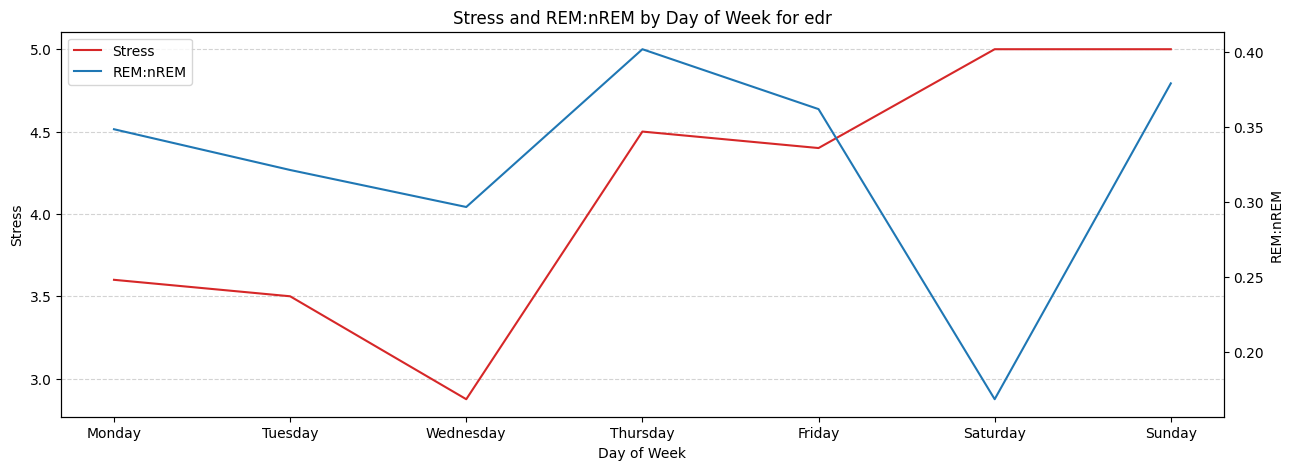

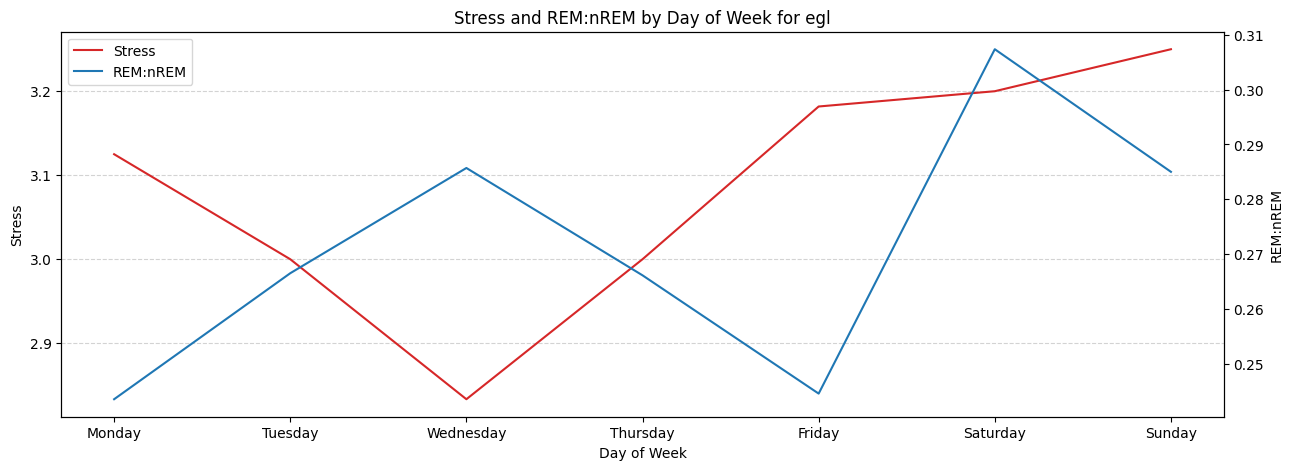

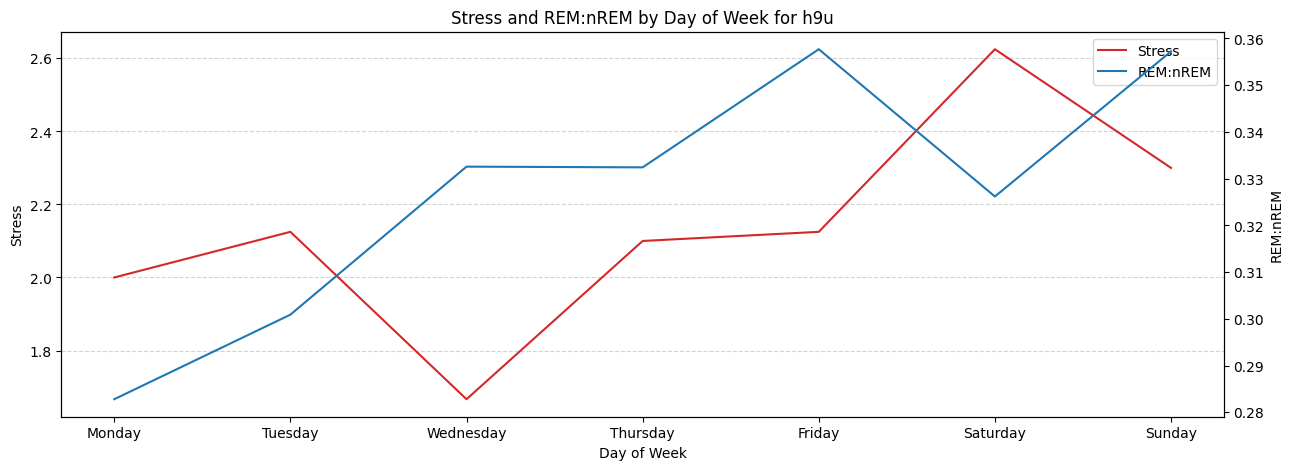

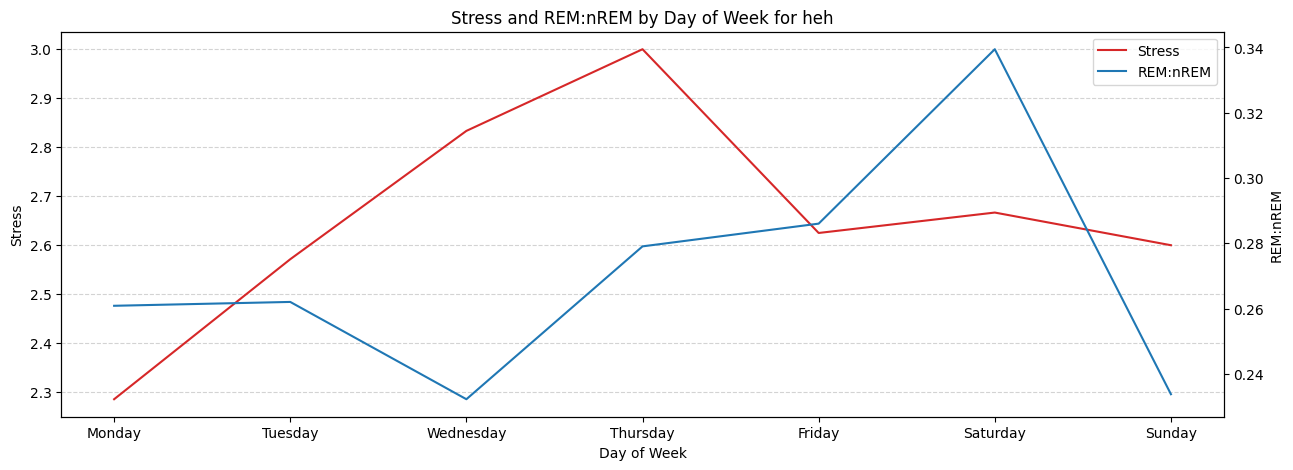

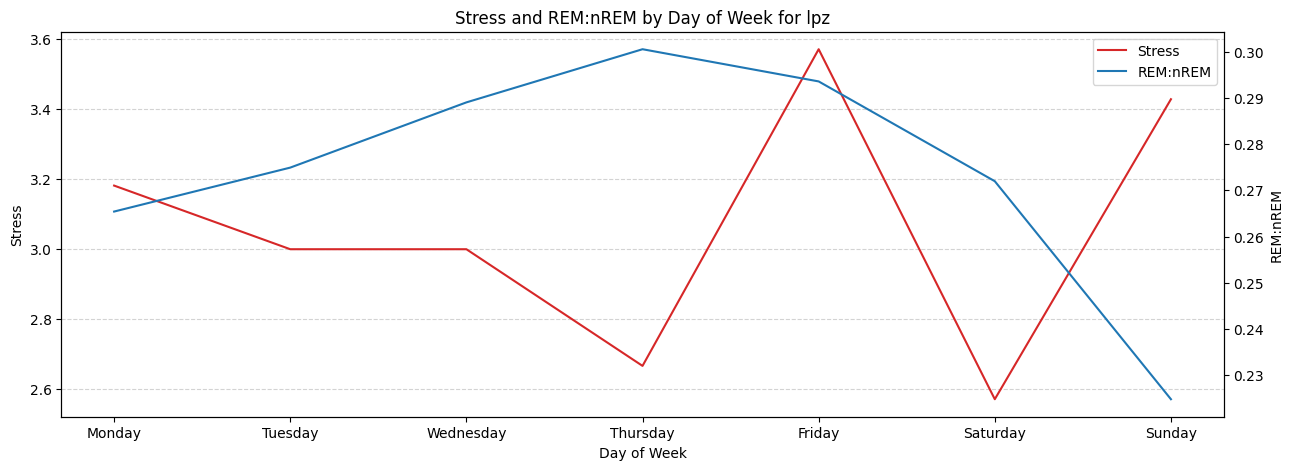

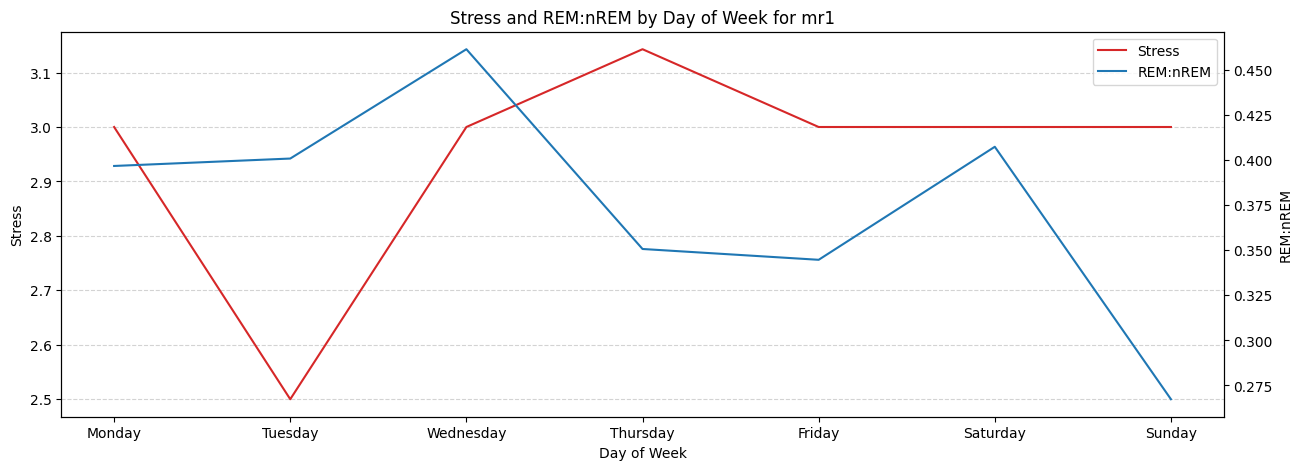

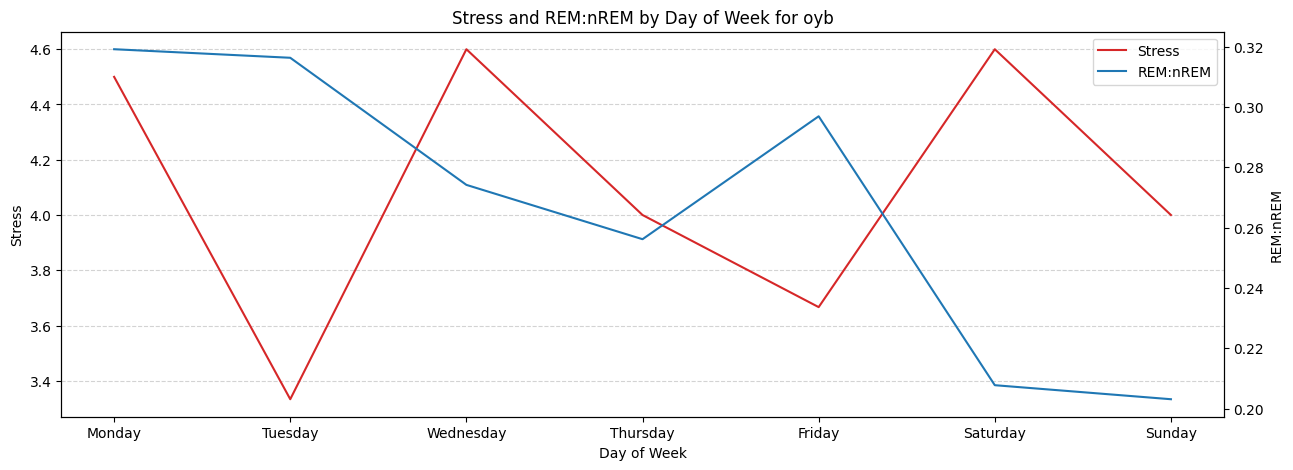

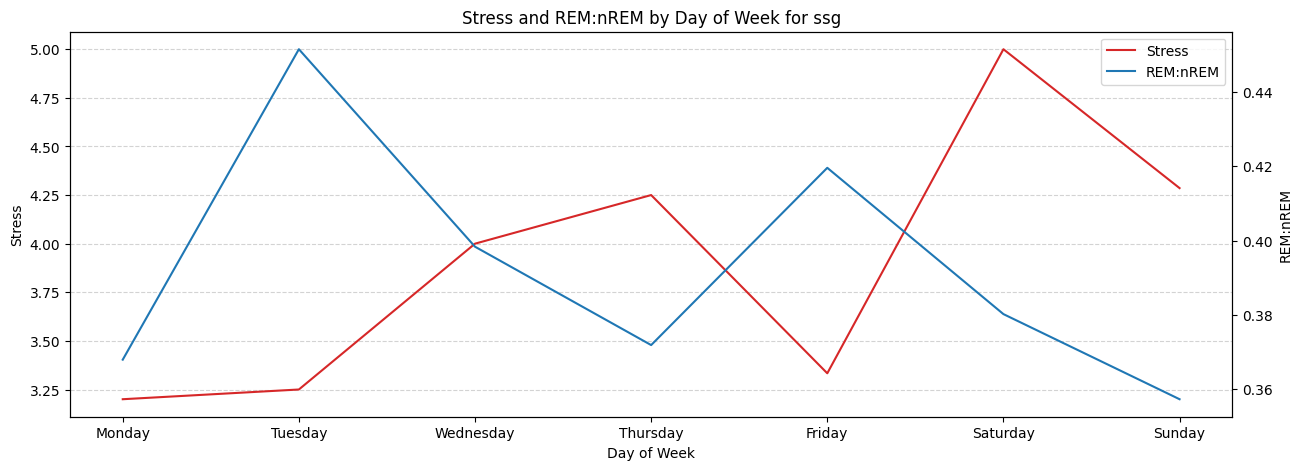

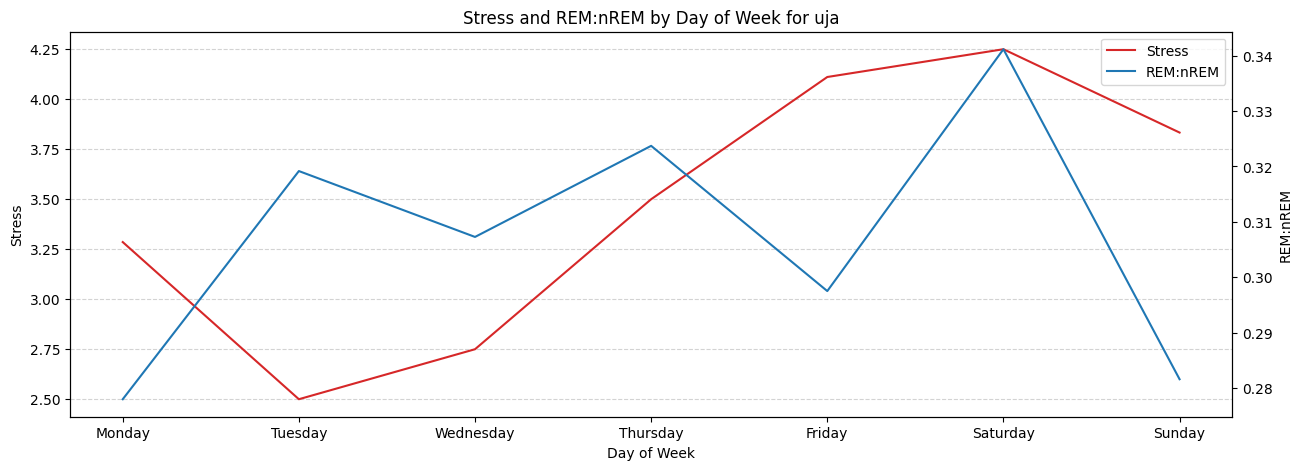

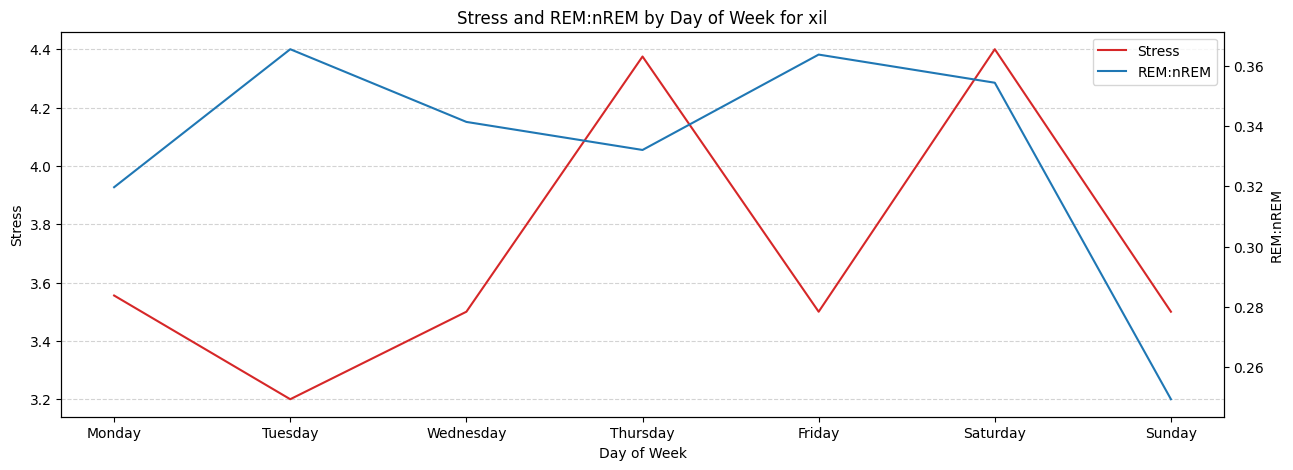

In [70]:
# plot stress and REM:nREM in df for each participant for each day_name ordered from Monday to Sunday
# be able to select which participant to plot by pid in dropdown where REM:nREM has second y axis
# stress and REM:nREM should be the same color according to pid


# plot from df for first participant
# lg1 = ax.plot(df[df['pid'] == 'edr']['day_name'], df[df['pid'] == 'edr']['stress'], color='tab:red', label='Stress')
# lg2 = ax2.plot(df[df['pid'] == 'edr']['day_name'], df[df['pid'] == 'edr']['REM:nREM'], color='tab:blue', label='REM:nREM')

# plot each participant in pids
for pid in pids:
    fig, ax = plt.subplots(figsize=(15,5))
    ax2 = ax.twinx()

    ax.set_title('Stress and REM:nREM by Day of Week for ' + pid)
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Stress')
    ax2.set_ylabel('REM:nREM')
    lg1 = ax.plot(df[df['pid'] == pid]['day_name'], df[df['pid'] == pid]['stress'], color='tab:red',label='Stress')
    lg2 = ax2.plot(df[df['pid'] == pid]['day_name'], df[df['pid'] == pid]['REM:nREM'], color='tab:blue',label='REM:nREM')
    # one legend
    leg = lg1 + lg2
    labs = [l.get_label() for l in leg]
    ax.legend(leg, labs, loc=0)

    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    ax.set_xticks(df[df['pid'] == 'edr']['day_name'])
plt.show()


In [71]:
# plot stress in df for each participant for each day_name ordered from Monday to Sunday
fig = px.line(df, x="day_name", y="stress", color="pid", 
                labels={
                    "stress": "Stress",
                    "day_name": "Day of Week",
                    "pid": "Participants"
                })
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.show()



In [72]:
# plot Stress agaisnt TST for each participant
fig = px.scatter(slpsteps, x="TST", y="stress", color="pid", trendline="ols", #points="all",
                labels={
                    "stress": "Stress",
                    "TST": "Total Sleep Time (hr)",
                    "pid": "Participants"
                })
fig.show()

In [73]:
# plot Sleep Rating against TST for each participant
fig = px.scatter(slpsteps, x="TST", y="sleep", color="pid", trendline="ols", #points="all",
                labels={
                    "sleep": "Sleep Rating",
                    "TST": "Total Sleep Time (hr)",
                    "pid": "Participants"
                })

fig.show()


In [74]:
# calculate correlation between TST and sleep rating for each participant
# initialize empty dataframe to store results of pearson correlation test for each participant
pearson_results = pd.DataFrame(columns=['pid', 'pearsonr'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get sleep duration for each participant
    dur = slpsteps[slpsteps['pid'] == i]['TST']
    # run pearson correlation test
    stat, p = pearsonr(dur, slpsteps[slpsteps['pid'] == i]['sleep'])
    # concat results to pearson_results dataframe
    pearson_results = pd.concat([pearson_results, pd.DataFrame({'pid':i, 'pearsonr':p}, index=[0])], ignore_index=True)

# round 5 decimals
pearson_results = pearson_results.round(5)
pearson_results

,pid,pearsonr
0,edr,0.00000
1,egl,0.00000
2,h9u,0.00010
3,heh,0.22826
4,lpz,0.00028
5,mr1,0.07861
6,oyb,0.15191
7,ssg,0.03837
8,uja,0.70080
9,xil,0.01325


In [75]:
# calculate correlation coefficient across all participants
stat, p = pearsonr(slpsteps['TST'], slpsteps['sleep'])
print('stat=%.4f, p=%.4f' % (stat, p))

stat=0.2647, p=0.0000


In [76]:
# square pearson correlation coefficient to get coefficient of determination
print('r^2=%.4f' % (stat**2))

r^2=0.0701


In [77]:
# plot productivity against TST for each participant
fig = px.scatter(slpsteps, x="TST", y="productivity", color="pid", trendline="ols", #points="all",
                labels={
                    "productivity": "Productivity",
                    "TST": "Total Sleep Time (hr)",
                    "pid": "Participants"
                })
fig.show()

In [78]:
# plot stress against REM:nREM for each participant
fig = px.scatter(slpsteps, x="REM:nREM", y="stress", color="pid", trendline="ols", #points="all",
                labels={
                    "stress": "Stress",
                    "REM:nREM": "REM:nREM",
                    "pid": "Participants"
                })
fig.show()

In [79]:
# plot stress by day of week for each participant
fig = px.box(slpsteps, x="day_name", y="stress", #color="pid", #points="all",
                labels={
                    "stress": "Stress",
                    "day_name": "Day of Week",
                    "pid": "Participants"
                })
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.show()

In [80]:
# plot Sleep Rating against REM:nREM for each participant
fig = px.scatter(slpsteps, x="REM:nREM", y="sleep", color="pid", trendline="ols", #points="all",
                labels={
                    "sleep": "Sleep Rating",
                    "pid": "Participants"
                })

fig.show()

In [81]:
# plot productivity against REM:nREM for each participant
fig = px.scatter(slpsteps, x="REM:nREM", y="productivity", color="pid", trendline="ols", #points="all",
                labels={
                    "productivity": "Productivity",
                    "pid": "Participants"
                })
fig.show()


In [82]:
# plot productivity against sleep rating for each participant
fig = px.scatter(slpsteps, x="sleep", y="productivity", color="pid", trendline="ols", #points="all",
                labels={
                    "productivity": "Productivity",
                    "sleep": "Sleep Rating",
                    "pid": "Participants"
                })
fig.show()


In [83]:
# plot stress against sleep rating for each participant
fig = px.scatter(slpsteps, x="sleep", y="stress", color="pid", trendline="ols", #points="all",
                labels={
                    "stress": "Stress",
                    "sleep": "Sleep Rating",
                    "pid": "Participants"
                })
fig.show()



In [84]:
# plot stress against step count for each participant
fig = px.scatter(slpsteps, x="steps", y="stress", color="pid", trendline="ols", #points="all",
                labels={
                    "stress": "Stress",
                    "steps": "Step Count",
                    "pid": "Participants"
                })
fig.show()


In [85]:
# plot stress against steps_norm for each participant
fig = px.scatter(slpsteps, x="steps", y="sleep", color="pid", trendline="ols", #points="all",
                labels={
                    "sleep": "SLeep Rating",
                    "pid": "Participants"
                })
fig.show()

In [86]:
# plot sleep rating against step count for each participant
fig = px.scatter(slpsteps, x="steps_std", y="sleep", color="pid", trendline="ols", #points="all",
                labels={
                    "sleep": "Sleep Rating",
                    "steps": "Step Count",
                    "pid": "Participants"
                })
fig.show()

In [87]:
# normaality test for steps for each participant using shapiro-wilk test
# test for normality for each participant
# create empty dataframe to store results of shapiro wilk test for each participant
shapiro_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get sleep duration for each participant
    step = slpsteps[slpsteps['pid'] == i]['steps']
    # run shapiro wilk test
    stat, p = shapiro(step)
    # concat results to shapiro_results dataframe
    shapiro_results = pd.concat([shapiro_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

# get rows where pvalue is less than 0.05
shapiro_results[shapiro_results['pvalue'] < 0.05]

,pid,pvalue
0,edr,0.035558
2,h9u,0.000391
4,lpz,0.001441
8,uja,0.016777


In [88]:
# plot productivity against step count for each participant
fig = px.scatter(slpsteps, x="steps_std", y="productivity", color="pid", trendline="ols", #points="all",
                labels={
                    "productivity": "Productivity",
                    "steps_std": "Standardardized Step",
                    "pid": "Participants"
                })
fig.show()


In [89]:
# create week column where values are either weekday or weekend
slpsteps['week'] = slpsteps['day_name'].apply(lambda x: 'weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'weekend')


In [90]:
# compare REM:nREM between weekday and weekend
fig = px.box(slpsteps, x="week", y="REM:nREM", #color="pid", #points="all",
                labels={
                    "week": "Weekday or Weekend",
                    "pid": "Participants"
                })
fig.show()


In [91]:
# compare TST between weekday and weekend
fig = px.box(slpsteps, x="week", y="TST", #color="pid", #points="all",
                labels={
                    "week": "Weekday or Weekend",
                    "pid": "Participants"
                })
fig.show()

In [92]:
# get number of rows for each participant that are weekday and weekend
slpsteps.groupby(['pid', 'week']).size()

pid  week   
edr  weekday    30
     weekend     3
egl  weekday    38
     weekend    13
h9u  weekday    41
     weekend    18
heh  weekday    37
     weekend    16
lpz  weekday    36
     weekend    14
mr1  weekday    24
     weekend    12
oyb  weekday    17
     weekend    12
ssg  weekday    25
     weekend    11
uja  weekday    34
     weekend    10
xil  weekday    30
     weekend    13
dtype: int64

In [93]:
# check if there is statistically significant difference between weekday and weekend REM:nREM using t-test
# create empty dataframe to store results of t-test for each participant
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get REM:nREM for each participant
    REMnREM = slpsteps[slpsteps['pid'] == i]['REM:nREM']
    # run t-test
    stat, p = ttest_ind(REMnREM[REMnREM.index.isin(slpsteps[slpsteps['week'] == 'weekday'].index)], REMnREM[REMnREM.index.isin(slpsteps[slpsteps['week'] == 'weekend'].index)])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

,pid,pvalue
0,edr,NaN
1,egl,0.110108
2,h9u,NaN
3,heh,0.755122
4,lpz,NaN
5,mr1,0.136391
6,oyb,NaN
7,ssg,NaN
8,uja,NaN
9,xil,NaN


In [94]:
# check if there is statistically significant difference between weekday and weekend TST using t-test
# create empty dataframe to store results
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get TST for each participant
    tst = slpsteps[slpsteps['pid'] == i]['TST']
    # run t-test
    stat, p = ttest_ind(tst[slpsteps['week'] == 'weekday'], tst[slpsteps['week'] == 'weekend'])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

,pid,pvalue
0,edr,0.300980
1,egl,0.396228
2,h9u,0.763087
3,heh,0.217539
4,lpz,0.502543
5,mr1,0.581253
6,oyb,0.537840
7,ssg,0.678378
8,uja,0.620019
9,xil,0.297310


In [95]:
# check if there is statistically significant difference between weekday and weekend sleep rating using t-test
# create empty dataframe to store results
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get sleep rating for each participant
    sleep = slpsteps[slpsteps['pid'] == i]['sleep']
    # run t-test
    stat, p = ttest_ind(sleep[slpsteps['week'] == 'weekday'], sleep[slpsteps['week'] == 'weekend'])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

,pid,pvalue
0,edr,0.727979
1,egl,0.578421
2,h9u,0.912700
3,heh,0.571954
4,lpz,0.541555
5,mr1,0.230204
6,oyb,0.820680
7,ssg,0.725249
8,uja,0.822569
9,xil,0.584874


In [96]:
# check if there is statistically significant difference between weekday and weekend productivity using t-test
# create empty dataframe to store results
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get productivity for each participant
    prod = slpsteps[slpsteps['pid'] == i]['productivity']
    # run t-test
    stat, p = ttest_ind(prod[slpsteps['week'] == 'weekday'], prod[slpsteps['week'] == 'weekend'])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76018/3873438777.py:10: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76018/3873438777.py:10: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,pid,pvalue
0,edr,0.006628
1,egl,0.434450
2,h9u,0.860103
3,heh,0.592464
4,lpz,0.553543
5,mr1,0.317257
6,oyb,0.547785
7,ssg,0.085072
8,uja,0.144694
9,xil,0.483673


In [97]:
# check if there is statistically significant difference between weekday and weekend stress using t-test
# create empty dataframe to store results
ttest_results = pd.DataFrame(columns=['pid', 'pvalue'])

# loop through each participant
for i in slpsteps['pid'].unique():
    # get stress for each participant
    stress = slpsteps[slpsteps['pid'] == i]['stress']
    # run t-test
    stat, p = ttest_ind(stress[slpsteps['week'] == 'weekday'], stress[slpsteps['week'] == 'weekend'])
    # concat results to ttest_results dataframe
    ttest_results = pd.concat([ttest_results, pd.DataFrame({'pid':i, 'pvalue':p}, index=[0])], ignore_index=True)

ttest_results

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76018/1574821872.py:10: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/var/folders/zd/_7gwj5650vb4smtfpkjw268h0000gn/T/ipykernel_76018/1574821872.py:10: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,pid,pvalue
0,edr,0.031904
1,egl,0.230184
2,h9u,0.086767
3,heh,0.903168
4,lpz,0.643615
5,mr1,0.759504
6,oyb,0.571826
7,ssg,0.076217
8,uja,0.041094
9,xil,0.673113


In [98]:
slpsteps.columns

Index(['pid', 'group', 'wakeDate', 'day_name', 'bedtime', 'wakeup', 'duration',
       'TST', 'REM:nREM', 'deep', 'light', 'rem', 'survey_index', 'EndDate',
       'sleep', 'Q4', 'rep_bedtime', 'rep_wakeup', 'activity', 'Q29', 'stress',
       'productivity', 'Q27_1', 'Q34', 'Q34_6_TEXT', 'Q35', 'repDuration',
       'diffDuration', 'night', 'duration_hr', 'zscore', 'outlier',
       'day_before', 'steps', 'steps_norm', 'steps_std', 'week'],
      dtype='object')

In [99]:
# get pid, group, wakeDate, bedtime, wakeup, 
# duration, TST, REM:nREM, deep, light, rem, sleep, Q4, rep_bedtime, rep_wakeup
slp = slpsteps[['pid', 'group', 'wakeDate', 'day_name', 'bedtime', 'wakeup', 'duration', 'TST', 'REM:nREM', 'deep', 'light', 'rem', 'sleep', 'Q4', 'rep_bedtime', 'rep_wakeup']]
slp.to_csv('slp.csv', index=False)